Esteban Castañeda Blanco C01795

Israel López Vallecillo C04396

Daniel Lizano Morales C04285

Ariel Solís Monge B97664

In [29]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import config

In [4]:
labeled_train_relative_set_size = round((config.LABELED_TRAIN_SET_ABSOLUTE_SIZE / (1 - config.UNLABELED_SET_SIZE)), 2)
labeled_test_relative_set_size = 1 - labeled_train_relative_set_size

## Datasets and dataloaders

In [3]:
data_transforms = {
    'all': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

In [6]:
full_dataset = datasets.ImageFolder(config.BASE_DIR_RAW, transform=data_transforms['all'])

In [7]:
indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

In [21]:
#Obtenemos el 20% de los datos 
train_val_indices, _ = train_test_split(indices, test_size=config.UNLABELED_SET_SIZE, stratify=labels, random_state=42)

#Obtenemos las etiquetas de los datos de entrenamiento
train_val_labels = [labels[i] for i in train_val_indices]

#dividir el 20% en 10% de entrenamiento y 10% de validación
train_indices, val_indices = train_test_split(train_val_indices, test_size=labeled_test_relative_set_size, stratify=train_val_labels, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=config.CNN_BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config.CNN_BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_loader.dataset)}")

Número de imágenes en el conjunto de entrenamiento: 6148
Número de imágenes en el conjunto de validación: 6149


## Function definitions

In [10]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [9]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), config.CNN_SAVE_PATH)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    
    return model

In [43]:
def evaluate_model(model_path, dataloader, device):
    model = models.efficientnet_b2(pretrained=False)
    new_in_channels = 1
    original_conv1 = model.features[0][0]

    new_conv1 = nn.Conv2d(
        in_channels=new_in_channels,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias
    )
    with torch.no_grad():
        if new_in_channels == 1:
            new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
        else:
            new_conv1.weight[:, :3] = original_conv1.weight
            if new_in_channels > 3:
                for i in range(3, new_in_channels):
                    new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)
    model.features[0][0] = new_conv1
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names=dataloader.dataset.dataset.classes)
    class_names = dataloader.dataset.dataset.classes
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print(f'Overall Accuracy: {accuracy:.4f}')
    print("\nMetrics by Class:")
    print("{:<20} {:<10} {:<10} {:<10}".format("Class", "Accuracy", "Precision", "Recall"))
    print("="*50)
    for class_name, class_accuracy, class_precision, class_recall in zip(class_names, class_accuracies, precision, recall):
        print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(class_name, class_accuracy, class_precision, class_recall))
    
    return accuracy

## CNN Classifier

In [23]:
# Set up of the device
if torch.backends.mps.is_available():
    device = torch.device("mps")#tqm
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
model = models.efficientnet_b2()

# Modify the first convolutional layer to accept a different number of input channels (e.g., 1 instead of 3)
new_in_channels = 1  # Change this to the desired number of input channels
original_conv1 = model.features[0][0]

new_conv1 = nn.Conv2d(
    in_channels=new_in_channels,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias
)

# Initialize the weights of the new conv layer
with torch.no_grad():
    if new_in_channels == 1:
        # Average the weights of the original conv layer across the input channels
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
    else:
        # Initialize weights by repeating the mean weights or use a different strategy
        new_conv1.weight[:, :3] = original_conv1.weight
        if new_in_channels > 3:
            for i in range(3, new_in_channels):
                new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)

# Replace the first convolutional layer in the model
model.features[0][0] = new_conv1

# Print the modified first convolutional layer
print("Modified first conv layer:", model.features[0][0])
# model._conv_stem = nn.Conv2d(1, model._conv_stem.out_channels, kernel_size=model._conv_stem.kernel_size, stride=model._conv_stem.stride, padding=model._conv_stem.padding, bias=False)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: mps
Modified first conv layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


### Training

In [ ]:
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=30, patience=5)


In [42]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

Using device: mps


### Evaluation

/Users/daniellizano/Documents/plant_disease_classification/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daniellizano/Documents/plant_disease_classification/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


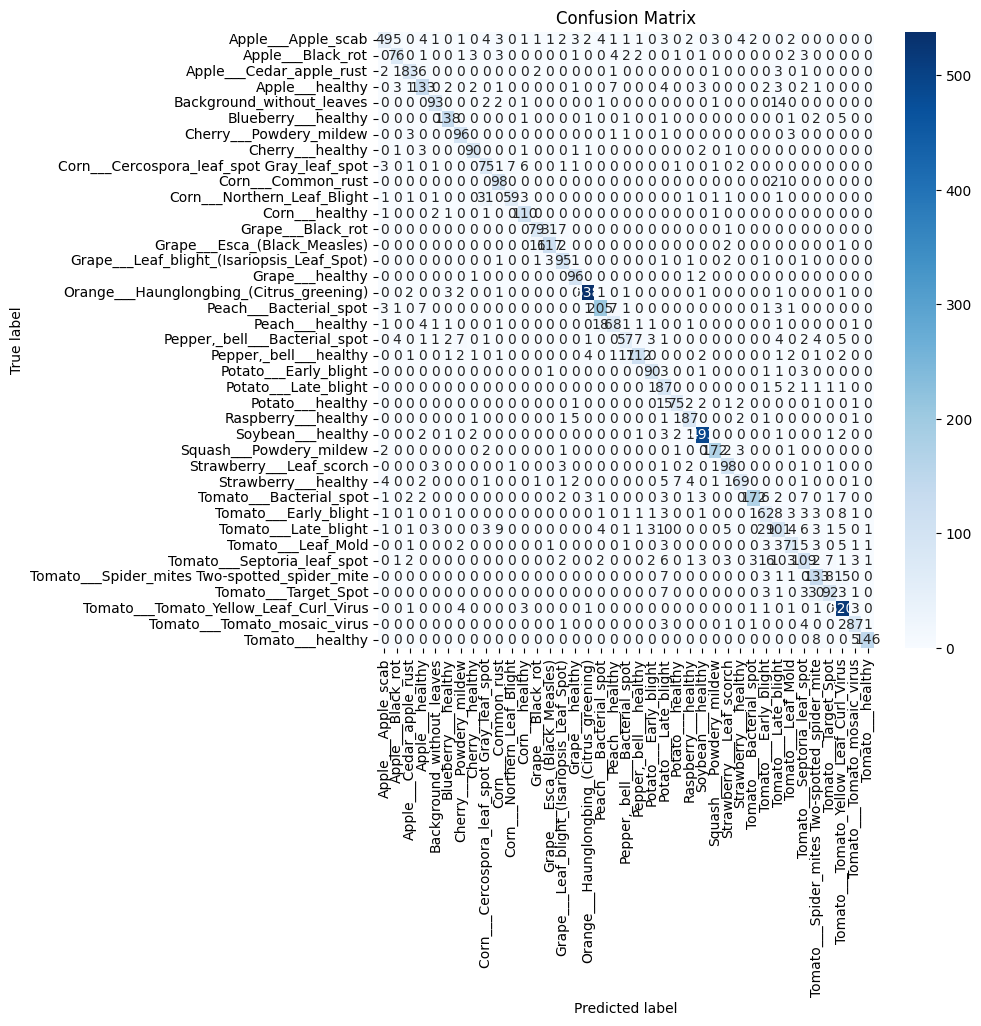

Overall Accuracy: 0.8344

Metrics by Class:
Class                Accuracy   Precision  Recall    
Apple___Apple_scab   0.4900     0.7101     0.4900    
Apple___Black_rot    0.7600     0.8261     0.7600    
Apple___Cedar_apple_rust 0.8300     0.8300     0.8300    
Apple___healthy      0.8061     0.8061     0.8061    
Background_without_leaves 0.8158     0.8774     0.8158    
Blueberry___healthy  0.9200     0.9200     0.9200    
Cherry___Powdery_mildew 0.9143     0.8348     0.9143    
Cherry___healthy     0.9000     0.9000     0.9000    
Corn___Cercospora_leaf_spot Gray_leaf_spot 0.7500     0.6250     0.7500    
Corn___Common_rust   0.8235     0.8099     0.8235    
Corn___Northern_Leaf_Blight 0.5900     0.8806     0.5900    
Corn___healthy       0.9483     0.8730     0.9483    
Grape___Black_rot    0.6695     0.7900     0.6695    
Grape___Esca_(Black_Measles) 0.8478     0.7597     0.8478    
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 0.8879     0.8051     0.8879    
Grape___healthy      

0.8344446251422996

In [45]:
evaluate_model('best_models/h1_80-10-10_classifierA.pth', val_loader, device)